In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import logging

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.core as dtfcore
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-ee4bd1b9-5a94-4e80-9766-78d8fde9494d.json'
INFO  # Git
  branch_name='CmTask5051_Port_Cx_ProdSystem_to_the_new_style'
  hash='31bf2944a'
  # Last commits:
    * 31bf2944a Nina Lee checkpoint                                                        (   4 hours ago) Thu Aug 24 16:59:26 2023  (HEAD -> CmTask5051_Port_Cx_ProdSystem_to_the_new_style, origin/CmTask5051_Port_Cx_ProdSystem_to_the_new_style)
    * caac00b99 Nina Lee checkpoint                                                        (   5 hours ago) Thu Aug 24 16:42:38 2023           
    *   65f9a7ba3 Nina Lee Merge branch 'master' into CmTask5051_Port_Cx_ProdSystem_to_the_new_style (   5 hours ago) Thu Aug 24 16:23:23 2023           
    |\  
# Machine info
  system=Linux
  node name=c24ced58c9eb
  release=5.15.0-1039-aws
  version=#44~20.04.1-Ubuntu SMP Thu Jun 22 12:21:12 UTC 2023
  machine=x86_64
  processor=x86_64

# Config

In [4]:
# TODO(Grisha): infer dag_builder_names (e.g., "C3a") automatically
# from `dag_builder_ctors`.
config = {
    "tiled_results_paths": {
        "C1b": "/shared_data/model/historical/build_tile_configs.C1b.ccxt_v7_1-all.5T.2022-01-01_2023-01-01.run0_rolling/tiled_results",
        "C3a": "/shared_data/model/historical/build_tile_configs.C3a.ccxt_v7_1-all.5T.2019-09-01_2023-02-01.run0_ins/tiled_results",
        "C8b": "/shared_data/model/historical/build_tile_configs.C8b.ccxt_v7_1-all.5T.2019-09-01_2023-02-01.run0_ins/tiled_results",
    },
    "dag_builder_ctors_as_str": {
        "C1b": "dataflow_orange.pipelines.C1.C1b_pipeline.C1b_DagBuilder",
        "C3a": "dataflow_orange.pipelines.C3.C3a_pipeline_tmp.C3a_DagBuilder_tmp",
        "C8b": "dataflow_orange.pipelines.C8.C8b_pipeline_tmp.C8b_DagBuilder_tmp",
    },
    "market_data_and_volatilty_dag_builder_name": "C3a",
    "infer_column_names_from_dag_builder": True,
    "column_tags": ["price", "volatility", "prediction"],
    "start_date": datetime.date(2022, 1, 1),
    "end_date": datetime.date(2022, 12, 31),
    "asset_id_col": "asset_id",
    "asset_ids": None,
    "freq": "D",
    "index_mode": "leave_unchanged",
    "annotate_forecasts_kwargs": {
        "quantization": 0,
        "burn_in_bars": 3,
        "style": "longitudinal",
        "initialize_beginning_of_day_trades_to_zero": False,
        "liquidate_at_end_of_day": False,
    },
}
# Specify the column names.
config["column_names"] = {}
if config["infer_column_names_from_dag_builder"]:
    # Infer column names from a `DagBuilder` object.
    for dag_builder_name, dag_builder_ctor_as_str in config[
        "dag_builder_ctors_as_str"
    ].items():
        dag_builder = dtfcore.get_DagBuilder_from_string(dag_builder_ctor_as_str)
        config["column_names"][
            dag_builder_name
        ] = dag_builder.get_column_names_dict(config["column_tags"])
else:
    # Set column names manually. See an example below.
    model_1_column_names = [
        "vwap",
        "vwap.ret_0.vol",
        "vwap.ret_0.vol_adj.shift_-2_hat",
    ]
    model_2_column_names = ["vwap", "garman_klass_vol", "feature"]
    model_3_column_names = ["vwap", "garman_klass_vol", "feature"]
    config["column_names"]["C1b"] = dict(
        zip(config["column_tags"], model_1_column_names)
    )
    config["column_names"]["C3a"] = dict(
        zip(config["column_tags"], model_2_column_names)
    )
    config["column_names"]["C8b"] = dict(
        zip(config["column_tags"], model_3_column_names)
    )
config = cconfig.Config().from_dict(config)
print(config)

tiled_results_paths: 
  C1b: /shared_data/model/historical/build_tile_configs.C1b.ccxt_v7_1-all.5T.2022-01-01_2023-01-01.run0_rolling/tiled_results
  C3a: /shared_data/model/historical/build_tile_configs.C3a.ccxt_v7_1-all.5T.2019-09-01_2023-02-01.run0_ins/tiled_results
  C8b: /shared_data/model/historical/build_tile_configs.C8b.ccxt_v7_1-all.5T.2019-09-01_2023-02-01.run0_ins/tiled_results
dag_builder_ctors_as_str: 
  C1b: dataflow_orange.pipelines.C1.C1b_pipeline.C1b_DagBuilder
  C3a: dataflow_orange.pipelines.C3.C3a_pipeline_tmp.C3a_DagBuilder_tmp
  C8b: dataflow_orange.pipelines.C8.C8b_pipeline_tmp.C8b_DagBuilder_tmp
market_data_and_volatilty_dag_builder_name: C3a
infer_column_names_from_dag_builder: True
column_tags: ['price', 'volatility', 'prediction']
start_date: 2022-01-01
end_date: 2022-12-31
asset_id_col: asset_id
asset_ids: None
freq: D
index_mode: leave_unchanged
annotate_forecasts_kwargs: 
  quantization: 0
  burn_in_bars: 3
  style: longitudinal
  initialize_beginning_of_d

# Initialize metadata and weights

In [6]:
# TODO(Grisha): @Dan Move to lib.
# Initialize dataframe pointing to the simulations.
res_dict = {}
res_dict["tiled_results_paths"] = config["tiled_results_paths"].to_dict()
res_dict["column_names"] = {}
for dag_builder_name, column_names in config["column_names"].to_dict().items():
    res_dict["column_names"][dag_builder_name] = column_names["prediction"]
simulations = pd.DataFrame.from_dict(res_dict, orient="columns")
simulations.columns = ["dir_name", "prediction_col"]
simulations

,dir_name,prediction_col
C1b,/shared_data/model/historical/build_tile_confi...,vwap.ret_0.vol_adj.shift_-2_hat
C3a,/shared_data/model/historical/build_tile_confi...,feature
C8b,/shared_data/model/historical/build_tile_confi...,feature


In [7]:
# TODO(Grisha): @Dan Move to lib.
# Initialize dataframe of weights.
weights_data = []
n_models = len(config["tiled_results_paths"])
for i in range(n_models):
    row = [0.0] * (n_models + 1)
    row[i] = 1.0
    row[-1] = 1 / n_models
    weights_data.append(row)
index = [key for key in config["tiled_results_paths"].to_dict()]
columns = index + ["equally_weighted"]
weights = pd.DataFrame(data=weights_data, index=index, columns=columns)
weights

,C1b,C3a,C8b,equally_weighted
C1b,1.0,0.0,0.0,0.333333
C3a,0.0,1.0,0.0,0.333333
C8b,0.0,0.0,1.0,0.333333


In [8]:
# TODO(Grisha): @Dan Move to lib.
dag_builder_name = config["market_data_and_volatilty_dag_builder_name"]
dag_column_names = config["column_names"][dag_builder_name].to_dict()
hdbg.dassert_in("price", dag_column_names)
hdbg.dassert_in("volatility", dag_column_names)
dir_name = config["tiled_results_paths"][dag_builder_name]
market_data_and_volatility = pd.DataFrame.from_dict(
    {
        "price": dag_column_names["price"],
        "volatility": dag_column_names["volatility"],
    },
    orient="index",
    columns=["col"],
)
market_data_and_volatility.insert(0, "dir_name", dir_name)
display(market_data_and_volatility)

,dir_name,col
price,/shared_data/model/historical/build_tile_confi...,vwap
volatility,/shared_data/model/historical/build_tile_confi...,garman_klass_vol


# Mix models

In [9]:
# This wraps ForecastEvaluator runs and aggregates results.
bar_metrics = dtfmod.evaluate_weighted_forecasts(
    simulations,
    weights,
    market_data_and_volatility,
    config["start_date"],
    config["end_date"],
    config["asset_id_col"],
    asset_ids=config["asset_ids"],
    annotate_forecasts_kwargs=config["annotate_forecasts_kwargs"],
    target_freq_str=None,
    index_mode=config["index_mode"],
)
bar_metrics.head()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO  spread is `None`; imputing spread_lower_bound=0.000100
INFO  spread is `None`; imputing spread_lower_bound=0.000100
INFO  spread is `None`; imputing spread_lower_bound=0.000100
INFO  spread is `None`; imputing spread_lower_bound=0.000100


C1b                                                                      C3a                                                                      C8b                                                             equally_weighted                                                            
                                   pnl   gross_volume     net_volume            gmv            nmv          pnl   gross_volume     net_volume            gmv            nmv          pnl   gross_volume     net_volume            gmv            nmv              pnl   gross_volume     net_volume            gmv            nmv
end_ts                                                                                                                                                                                                                                                                                                                           
2022-01-01 00:15:00+00:00  -466.775324       0.000000       0.000000  923763.606777  505215.525822  -198.869980       0.000000       0.000000  923763.606777  451407.335569 -1330.656773       0.000000       0.000000  923763.606777  737675.011842     -1330.656773       0.000000       0.000000  923763.606777  737675.011842
2022-01-01 00:20:00+00:00   235.698055       0.000000       0.000000  924087.251831  505451.223877   152.207940       0.000000       0.000000  924087.251831  451559.543509   295.539783       0.000000       0.000000  924087.251831  737970.551626       295.539783       0.000000       0.000000  924087.251831  737970.551626
2022-01-01 00:25:00+00:00  1628.732537       0.000000       0.000000  926404.992649  507079.956414  1271.102739       0.000000       0.000000  926404.992649  452830.646249  2118.166702       0.000000       0.000000  926404.992649  740088.718328      2118.166702       0.000000       0.000000  926404.992649  740088.718328
2022-01-01 00:30:00+00:00   318.530699  927112.398424 -507398.487114            NaN            NaN    46.526153  927112.398424 -452877.172402            NaN            NaN   761.536803  927112.398424 -740850.255131            NaN            NaN       761.536803  927112.398424 -740850.255131            NaN            NaN
2022-01-01 00:35:00+00:00          NaN            NaN            NaN            NaN            NaN          NaN            NaN            NaN            NaN            NaN          NaN            NaN            NaN            NaN            NaN              NaN            NaN            NaN            NaN            NaN

In [10]:
bar_metrics.tail()

C1b                                 C3a                                 C8b                                 equally_weighted                                
                          pnl gross_volume net_volume gmv nmv pnl gross_volume net_volume gmv nmv pnl gross_volume net_volume gmv nmv              pnl gross_volume net_volume gmv nmv
end_ts                                                                                                                                                                                
2022-12-31 23:35:00+00:00 NaN          NaN        NaN NaN NaN NaN          NaN        NaN NaN NaN NaN          NaN        NaN NaN NaN              NaN          NaN        NaN NaN NaN
2022-12-31 23:40:00+00:00 NaN          NaN        NaN NaN NaN NaN          NaN        NaN NaN NaN NaN          NaN        NaN NaN NaN              NaN          NaN        NaN NaN NaN
2022-12-31 23:45:00+00:00 NaN          NaN        NaN NaN NaN NaN          NaN        NaN NaN NaN NaN          NaN        NaN NaN NaN              NaN          NaN        NaN NaN NaN
2022-12-31 23:50:00+00:00 NaN          NaN        NaN NaN NaN NaN          NaN        NaN NaN NaN NaN          NaN        NaN NaN NaN              NaN          NaN        NaN NaN NaN
2022-12-31 23:55:00+00:00 NaN          NaN        NaN NaN NaN NaN          NaN        NaN NaN NaN NaN          NaN        NaN NaN NaN              NaN          NaN        NaN NaN NaN

[2.2623186485540403, 1.8812768263033914, 1.457751659195455]

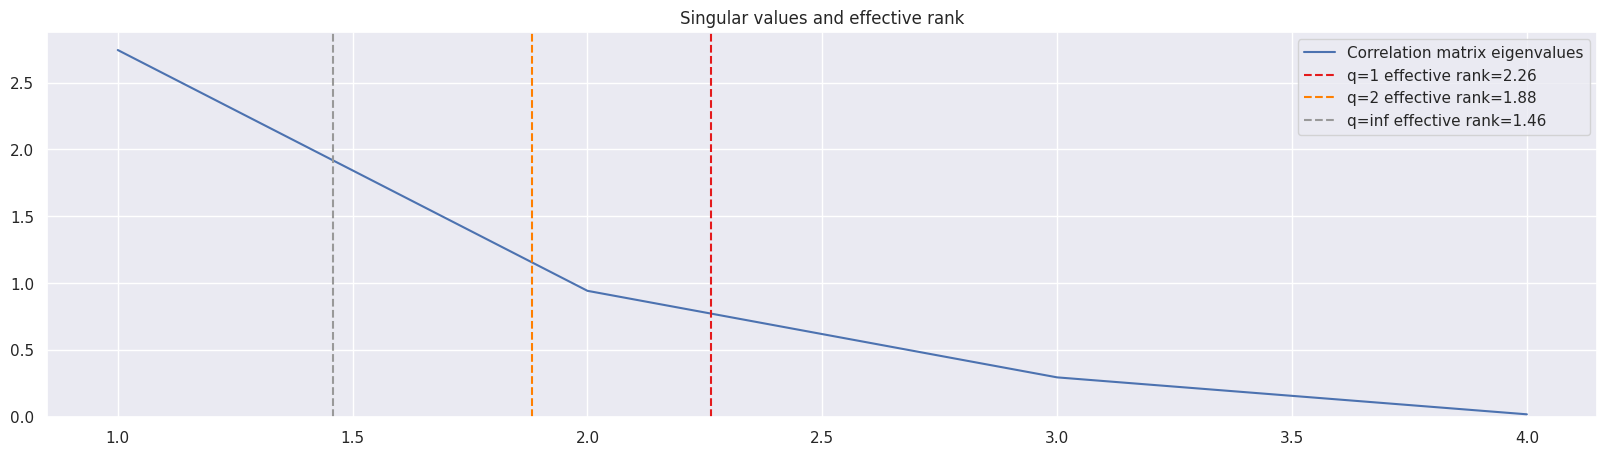

In [11]:
coplotti.plot_effective_correlation_rank(
    bar_metrics.xs("pnl", level=1, axis=1, drop_level=True)
)

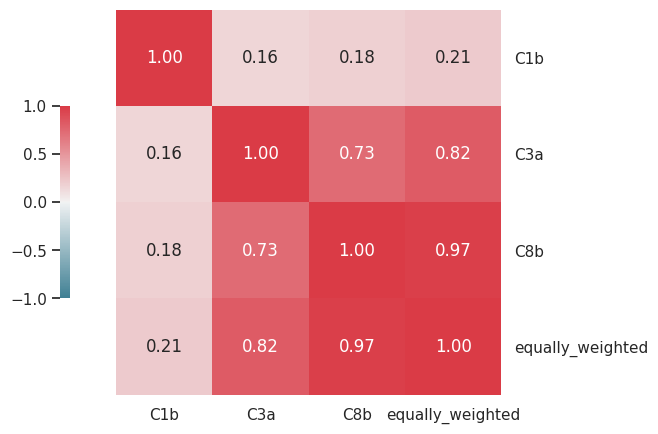

In [12]:
corr_matrix = bar_metrics.xs("pnl", level=1, axis=1, drop_level=True).corr()
coplotti.plot_heatmap(corr_matrix)

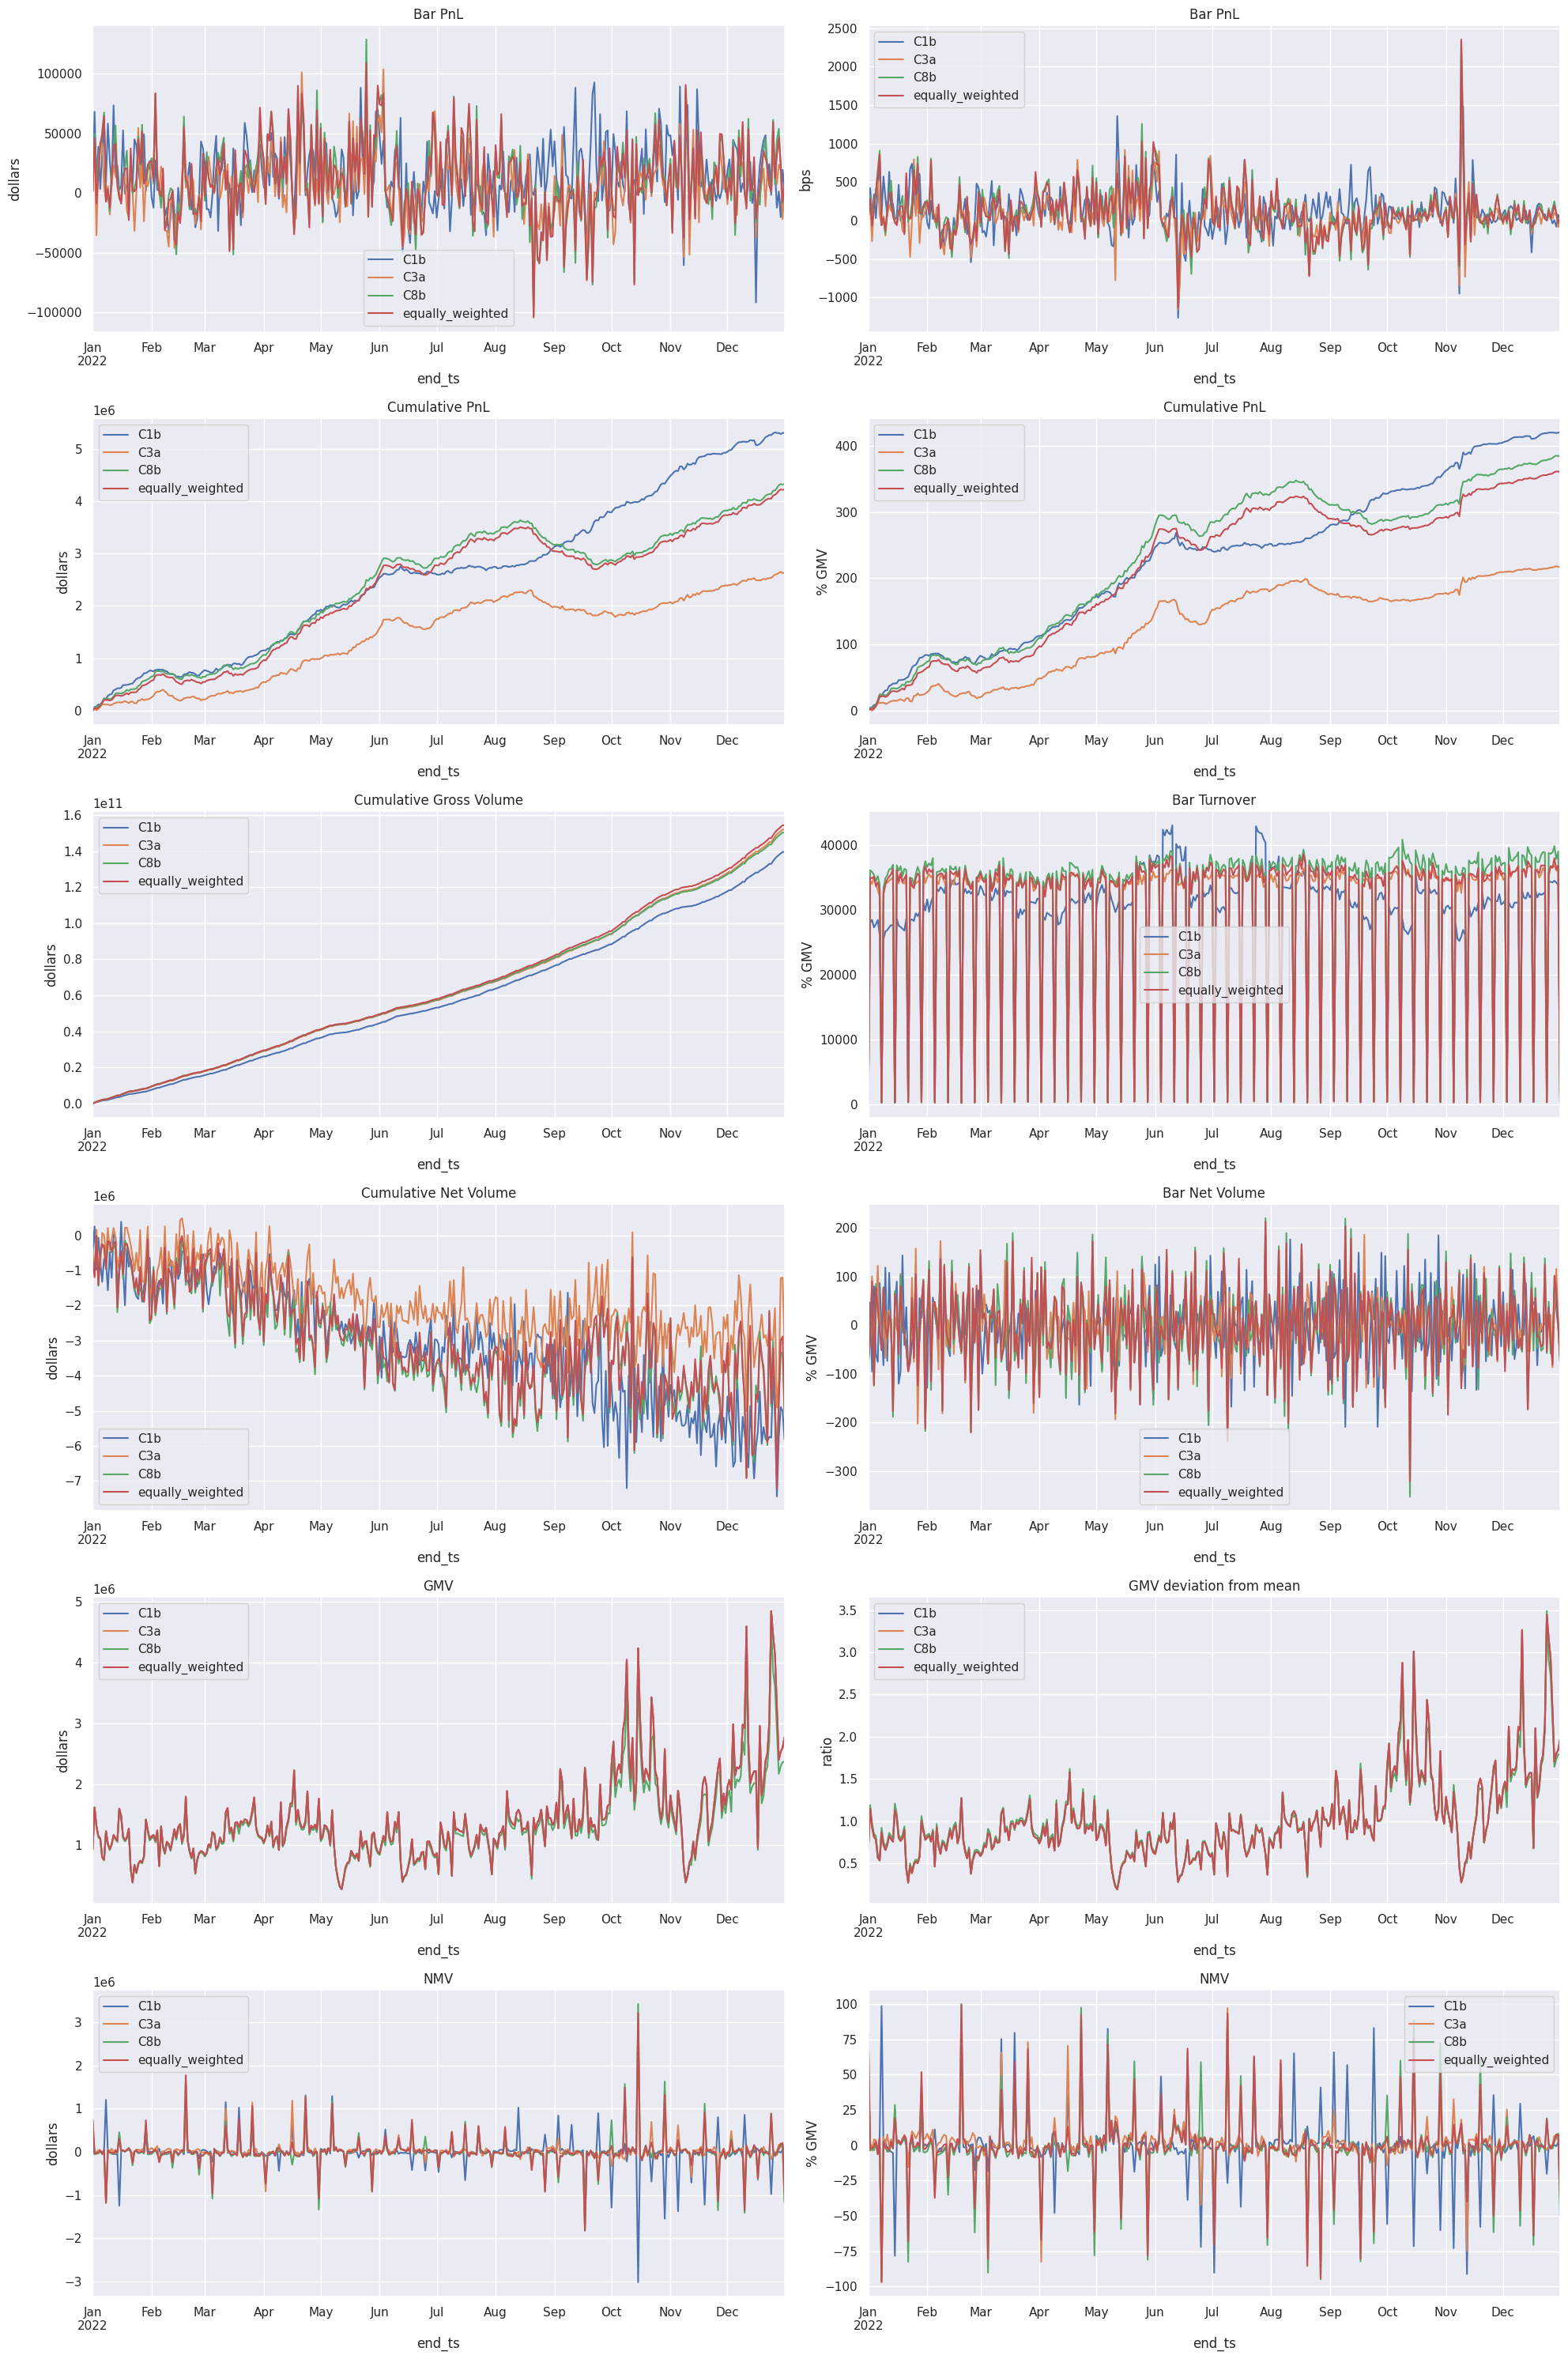

In [13]:
coplotti.plot_portfolio_stats(bar_metrics, freq=config["freq"])

In [14]:
stats_computer = dtfmod.StatsComputer()
#
portfolio_stats, daily_metrics = stats_computer.compute_portfolio_stats(
    bar_metrics,
    config["freq"],
)
with pd.option_context("display.float_format", "{:,.2f}".format):
    display(portfolio_stats)

C1b            C3a            C8b  equally_weighted
ratios     sharpe_ratio                         10.48           5.45           7.27              7.15
           sharpe_ratio_standard_error           1.07           1.02           1.04              1.04
           sr.tval                              10.47           5.45           7.27              7.14
           sr.pval                               0.00           0.00           0.00              0.00
           kratio                                6.69           2.87           2.70              2.79
dollar     gmv_mean                      1,406,735.27   1,406,683.66   1,320,559.86      1,406,736.45
           gmv_stdev                       687,314.13     687,223.71     596,603.68        687,319.39
           annualized_mean_return        5,308,653.44   2,635,765.93   4,325,268.00      4,225,498.40
           annualized_volatility           506,781.94     483,879.51     595,143.00        591,316.12
           max_drawdown                    160,156.14     509,086.87     847,165.19        804,113.34
           pnl_mean                         14,534.30       7,216.33      11,841.94         11,568.78
           pnl_std                          26,517.10      25,318.74      31,140.55         30,940.31
           turnover_mean               382,274,003.02 416,347,182.55 411,733,708.15    422,697,155.54
           turnover_stdev              247,216,668.73 273,882,952.42 263,123,795.73    277,252,093.09
           market_bias_mean                -13,873.77      18,564.21      -2,425.31          6,910.77
           market_bias_stdev               323,726.76     291,915.66     367,721.21        347,437.12
percentage annualized_mean_return              377.37         187.37         327.53            300.38
           annualized_volatility                36.03          34.40          45.07             42.03
           max_drawdown                         11.38          36.19          64.15             57.16
           pnl_mean                              1.03           0.51           0.90              0.82
           pnl_std                               1.89           1.80           2.36              2.20
           turnover_mean                    27,174.55      29,597.78      31,178.72         30,048.07
           turnover_stdev                   17,573.79      19,470.12      19,925.17         19,708.89
           market_bias_mean                     -0.99           1.32          -0.18              0.49
           market_bias_stdev                    23.01          20.75          27.85             24.70